# OCT Image Dataset Preparation & Two-Stage Contrastive Learning

## 目标
1. **数据准备**: 创建两个数据集
   - `all_images_df`: 所有OCT图片 (~30,000张) → 用于SimCLR
   - `biomarker_df`: 有biomarker标签的图片 (~3,920张) → 用于SupCon

2. **两阶段训练**:
   - Stage 1: SimCLR on 全部图片 → 学习通用OCT视觉特征
   - Stage 2: SupCon fine-tune on biomarker图片 → 注入临床语义 (同一个encoder，Stage 2是在Stage 1基础上继续微调)


         ImageNet预训练权重, RESNET18

               ↓
            Stage 1 (SimCLR, 33000张)Encoder学会"看"所有visit的OCT

               ↓
            同一个encoder权重更新

               ↓
            Stage 2 (SupCon, 3920张)注入biomarker临床语义

               ↓
            最终encoder → 用于下游任务


## 优势
- 数据量增加 ~8倍，显著减少过拟合
- Encoder见过所有visit的图像，泛化更好
- 保留biomarker语义信息


## Q: 现在先用所有图片数据学到了image modality的encoder，那之后在每个时间步骤上面这一模态的表达都是相同的？
Encoder相同，但输出embedding不同！Encoder参数共享是正确的 — 这叫 weight sharing，是处理序列数据的标准做法。
## 类比

| 概念 | 类比 |
|------|------|
| Encoder | 相机 |
| 输入图片 | 不同场景 |
| Embedding | 拍出的照片 |

---
# Part 1: Data Preparation

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm import tqdm
from datetime import datetime
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.0.1
CUDA available: True
GPU: NVIDIA GeForce RTX 4090


In [2]:
SEED = 42
DATA_ROOT = './Prime Images'
BIOMARKER_CSV = './2_biomarker_processed.csv'
OUTPUT_DIR = './supcon_output_2stages'
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, 'checkpoints')
FIGURES_DIR = os.path.join(OUTPUT_DIR, 'figures')
DATA_DIR = os.path.join(OUTPUT_DIR, 'data')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## 1.1 扫描所有OCT图片

In [3]:
def scan_all_oct_images(data_root):
    """
    扫描所有OCT图片，返回DataFrame。
    目录结构: DATA_ROOT/Prime_FULL/Patient_ID/Visit/Eye/*.tif
    """
    records = []
    
    # 进入 Prime_FULL 子目录
    prime_full_path = os.path.join(data_root, 'Prime_FULL')
    if not os.path.isdir(prime_full_path):
        print(f"Warning: {prime_full_path} not found, trying data_root directly")
        prime_full_path = data_root
    
    patients = sorted([d for d in os.listdir(prime_full_path) 
                       if os.path.isdir(os.path.join(prime_full_path, d))])
    
    for patient in tqdm(patients, desc='Scanning patients'):
        patient_path = os.path.join(prime_full_path, patient)
        
        for visit in os.listdir(patient_path):
            visit_path = os.path.join(patient_path, visit)
            if not os.path.isdir(visit_path):
                continue
            
            for eye in ['OD', 'OS']:
                eye_path = os.path.join(visit_path, eye)
                if not os.path.isdir(eye_path):
                    continue
                
                # 找所有图片
                for img_file in os.listdir(eye_path):
                    if img_file.endswith(('.tif', '.png', '.jpg')):
                        img_path = os.path.join(eye_path, img_file)
                        
                        # 提取B-scan编号
                        try:
                            b_scan_num = int(img_file.split('.')[0])
                        except:
                            b_scan_num = -1
                        
                        records.append({
                            'patient_id': patient,
                            'visit': visit,
                            'eye': eye,
                            'b_scan_num': b_scan_num,
                            'filename': img_file,
                            'full_path': img_path,
                            'relative_path': os.path.relpath(img_path, data_root)
                        })
    
    df = pd.DataFrame(records)
    print(f"\nTotal images found: {len(df):,}")
    print(f"Unique patients: {df['patient_id'].nunique()}")
    print(f"Unique visits: {df.groupby(['patient_id', 'visit']).ngroups}")
    
    return df

# 扫描所有图片
all_images_df = scan_all_oct_images(DATA_ROOT)

Scanning patients: 100%|██████████| 40/40 [00:00<00:00, 45.93it/s]


Total images found: 65,520
Unique patients: 40
Unique visits: 660


In [4]:
# 查看数据分布
print("=" * 50)
print("DATA DISTRIBUTION")
print("=" * 50)

print(f"\nTotal images: {len(all_images_df):,}")
print(f"\nImages per patient:")
print(all_images_df.groupby('patient_id').size().describe())

print(f"\nVisits per patient:")
visits_per_patient = all_images_df.groupby('patient_id')['visit'].nunique()
print(visits_per_patient.describe())

print(f"\nSample rows:")
all_images_df.head()

DATA DISTRIBUTION

Total images: 65,520

Images per patient:
count      40.000000
mean     1638.000000
std       527.234925
min       306.000000
25%      1413.000000
50%      1835.500000
75%      2040.000000
max      2142.000000
dtype: float64

Visits per patient:
count    40.0000
mean     16.5000
std       4.8885
min       3.0000
25%      14.0000
50%      19.0000
75%      20.0000
max      21.0000
Name: visit, dtype: float64

Sample rows:


,patient_id,visit,eye,b_scan_num,filename,full_path,relative_path
0,01-001,W0,OD,0,0.png,./Prime Images\Prime_FULL\01-001\W0\OD\0.png,Prime_FULL\01-001\W0\OD\0.png
1,01-001,W0,OD,1,1.png,./Prime Images\Prime_FULL\01-001\W0\OD\1.png,Prime_FULL\01-001\W0\OD\1.png
2,01-001,W0,OD,10,10.png,./Prime Images\Prime_FULL\01-001\W0\OD\10.png,Prime_FULL\01-001\W0\OD\10.png
3,01-001,W0,OD,11,11.png,./Prime Images\Prime_FULL\01-001\W0\OD\11.png,Prime_FULL\01-001\W0\OD\11.png
4,01-001,W0,OD,12,12.png,./Prime Images\Prime_FULL\01-001\W0\OD\12.png,Prime_FULL\01-001\W0\OD\12.png


## 1.2 加载Biomarker数据并匹配

In [5]:
biomarker_df = pd.read_csv(BIOMARKER_CSV)
print(f"Biomarker records: {len(biomarker_df):,}")
print(f"Columns: {list(biomarker_df.columns)}")

Biomarker records: 3,920
Columns: ['Path (Trial/Arm/Folder/Visit/Eye/Image Name)', 'Scan (n/49)', 'Atrophy / thinning of retinal layers', 'Disruption of EZ', 'DRIL', 'IR hemorrhages', 'IR HRF', 'Partially attached vitreous face', 'Fully attached vitreous face', 'Preretinal tissue/hemorrhage', 'Vitreous debris', 'VMT', 'DRT/ME', 'Fluid (IRF)', 'Fluid (SRF)', 'Disruption of RPE', 'PED (serous)', 'SHRM', 'Eye_ID', 'BCVA', 'CST', 'Patient_ID', 'Patient_ID_String', 'Week', 'Eye', 'OCT_Filename', 'B_scan_number']


In [6]:
# 创建匹配的路径key
# biomarker_df的路径列
path_col = 'Path (Trial/Arm/Folder/Visit/Eye/Image Name)'

def normalize_path(path):
    """标准化路径用于匹配"""
    if pd.isna(path):
        return None
    # 去除开头的斜杠，统一分隔符
    path = str(path).lstrip('/').replace('\\', '/')
    return path

biomarker_df['normalized_path'] = biomarker_df[path_col].apply(normalize_path)
all_images_df['normalized_path'] = all_images_df['relative_path'].apply(normalize_path)

# 创建biomarker路径集合
biomarker_paths = set(biomarker_df['normalized_path'].dropna())
print(f"Unique biomarker paths: {len(biomarker_paths)}")

# 标记哪些图片有biomarker
all_images_df['has_biomarker'] = all_images_df['normalized_path'].isin(biomarker_paths)

print(f"\nImages with biomarker: {all_images_df['has_biomarker'].sum():,}")
print(f"Images without biomarker: {(~all_images_df['has_biomarker']).sum():,}")

Unique biomarker paths: 3920

Images with biomarker: 3,920
Images without biomarker: 61,600


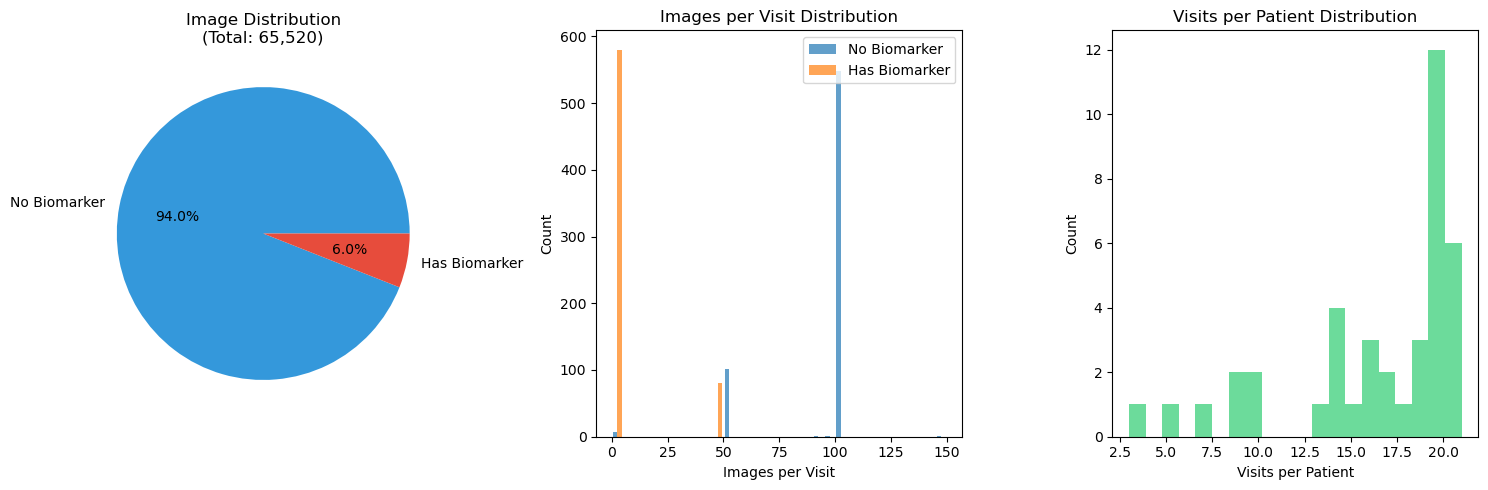

In [7]:
# 可视化数据分布
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Biomarker vs Non-biomarker
counts = all_images_df['has_biomarker'].value_counts()
axes[0].pie([counts[False], counts[True]], 
            labels=['No Biomarker', 'Has Biomarker'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'])
axes[0].set_title(f'Image Distribution\n(Total: {len(all_images_df):,})')

# 2. Images per visit (biomarker vs non-biomarker)
visit_counts = all_images_df.groupby(['patient_id', 'visit', 'has_biomarker']).size().unstack(fill_value=0)
axes[1].hist([visit_counts[False], visit_counts[True] if True in visit_counts.columns else []], 
             bins=30, label=['No Biomarker', 'Has Biomarker'], alpha=0.7)
axes[1].set_xlabel('Images per Visit')
axes[1].set_ylabel('Count')
axes[1].set_title('Images per Visit Distribution')
axes[1].legend()

# 3. Visits per patient
axes[2].hist(visits_per_patient, bins=20, color='#2ecc71', alpha=0.7)
axes[2].set_xlabel('Visits per Patient')
axes[2].set_ylabel('Count')
axes[2].set_title('Visits per Patient Distribution')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/data_distribution.png', dpi=150)
plt.show()

## 1.3 创建训练/验证集 (Patient-level split)

In [8]:
# Patient-level split
all_patients = all_images_df['patient_id'].unique()
train_patients, val_patients = train_test_split(
    all_patients, test_size=0.2, random_state=SEED
)

print(f"Train patients: {len(train_patients)}")
print(f"Val patients: {len(val_patients)}")

# Split all images
all_images_df['split'] = all_images_df['patient_id'].apply(
    lambda x: 'train' if x in train_patients else 'val'
)

# Create separate DataFrames
train_all_df = all_images_df[all_images_df['split'] == 'train'].copy()
val_all_df = all_images_df[all_images_df['split'] == 'val'].copy()

train_biomarker_df = train_all_df[train_all_df['has_biomarker']].copy()
val_biomarker_df = val_all_df[val_all_df['has_biomarker']].copy()

print(f"\n{'='*50}")
print("DATASET SIZES")
print(f"{'='*50}")
print(f"\nAll Images:")
print(f"  Train: {len(train_all_df):,}")
print(f"  Val: {len(val_all_df):,}")
print(f"\nBiomarker Images:")
print(f"  Train: {len(train_biomarker_df):,}")
print(f"  Val: {len(val_biomarker_df):,}")

Train patients: 32
Val patients: 8

DATASET SIZES

All Images:
  Train: 54,198
  Val: 11,322

Biomarker Images:
  Train: 3,136
  Val: 784


In [9]:
# 为biomarker图片添加标签
SELECTED_BIOMARKERS = [
    'IR HRF', 'Fully attached vitreous face', 'Vitreous debris',
    'Partially attached vitreous face', 'Fluid (IRF)', 'DRT/ME'
]

def create_label(row, cols):
    return '_'.join([str(int(row[col])) for col in cols])

biomarker_df['label_str'] = biomarker_df.apply(
    lambda row: create_label(row, SELECTED_BIOMARKERS), axis=1
)

label_counts = biomarker_df['label_str'].value_counts()
label_to_idx = {label: idx for idx, label in enumerate(label_counts.index)}
biomarker_df['label_idx'] = biomarker_df['label_str'].map(label_to_idx)

# Merge labels to train/val biomarker dataframes
label_mapping = biomarker_df.set_index('normalized_path')['label_idx'].to_dict()

train_biomarker_df['label_idx'] = train_biomarker_df['normalized_path'].map(label_mapping)
val_biomarker_df['label_idx'] = val_biomarker_df['normalized_path'].map(label_mapping)

# 移除没有匹配到label的行
train_biomarker_df = train_biomarker_df.dropna(subset=['label_idx'])
val_biomarker_df = val_biomarker_df.dropna(subset=['label_idx'])
train_biomarker_df['label_idx'] = train_biomarker_df['label_idx'].astype(int)
val_biomarker_df['label_idx'] = val_biomarker_df['label_idx'].astype(int)

print(f"Unique labels: {len(label_to_idx)}")
print(f"Train biomarker samples with labels: {len(train_biomarker_df)}")
print(f"Val biomarker samples with labels: {len(val_biomarker_df)}")

Unique labels: 48
Train biomarker samples with labels: 3136
Val biomarker samples with labels: 784


In [10]:
DATA_DIR

'./supcon_output_2stages\\data'

In [11]:
# 保存处理好的数据
train_all_df.to_csv(f'{DATA_DIR}/train_all_images.csv', index=False)
val_all_df.to_csv(f'{DATA_DIR}/val_all_images.csv', index=False)
train_biomarker_df.to_csv(f'{DATA_DIR}/train_biomarker_images.csv', index=False)
val_biomarker_df.to_csv(f'{DATA_DIR}/val_biomarker_images.csv', index=False)

# 保存label mapping
with open(f'{DATA_DIR}/label_mapping.json', 'w') as f:
    json.dump(label_to_idx, f, indent=2)

print(f"Data saved to {DATA_DIR}/")
print(f"  - train_all_images.csv: {len(train_all_df):,} rows")
print(f"  - val_all_images.csv: {len(val_all_df):,} rows")
print(f"  - train_biomarker_images.csv: {len(train_biomarker_df):,} rows")
print(f"  - val_biomarker_images.csv: {len(val_biomarker_df):,} rows")

Data saved to ./supcon_output_2stages\data/
  - train_all_images.csv: 54,198 rows
  - val_all_images.csv: 11,322 rows
  - train_biomarker_images.csv: 3,136 rows
  - val_biomarker_images.csv: 784 rows


---
# Part 2: Dataset Classes and Model

In [12]:
# ============================================================
# Training Configuration
# ============================================================

# Stage 1: SimCLR on all images
STAGE1_EPOCHS = 50
STAGE1_LR = 0.001
STAGE1_BATCH_SIZE = 128

# Stage 2: SupCon fine-tune on biomarker images
STAGE2_EPOCHS = 30
STAGE2_LR = 0.0001      # 更小的LR用于fine-tune
STAGE2_BATCH_SIZE = 64

# Common settings
TEMPERATURE = 0.2        # 较高温度，更平滑
EMBEDDING_DIM = 256
PROJECTION_DIM = 64
PROJECTION_DROPOUT = 0.3
WEIGHT_DECAY = 5e-4
IMAGE_SIZE = 224

# Evaluation
EVAL_EVERY = 5
PATIENCE = 10

print("Training Configuration:")
print(f"  Stage 1 (SimCLR): {STAGE1_EPOCHS} epochs, LR={STAGE1_LR}")
print(f"  Stage 2 (SupCon): {STAGE2_EPOCHS} epochs, LR={STAGE2_LR}")
print(f"  Temperature: {TEMPERATURE}")

Training Configuration:
  Stage 1 (SimCLR): 50 epochs, LR=0.001
  Stage 2 (SupCon): 30 epochs, LR=0.0001
  Temperature: 0.2


In [13]:
# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.85, 1.15)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined")

Transforms defined


In [14]:
class SimCLRDataset(Dataset):
    """
    Dataset for SimCLR - returns two augmented views, no labels needed.
    用于Stage 1: 在所有图片上训练。
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['full_path']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # 返回随机噪声图片作为fallback
            image = Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8))
        
        if self.transform:
            view1 = self.transform(image)
            view2 = self.transform(image)
        else:
            view1 = view2 = transforms.ToTensor()(image)
            
        return view1, view2


class SupConDataset(Dataset):
    """
    Dataset for SupCon - returns two augmented views WITH labels.
    用于Stage 2: 在有biomarker标签的图片上训练。
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['full_path']
        label = row['label_idx']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            image = Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8))
        
        if self.transform:
            view1 = self.transform(image)
            view2 = self.transform(image)
        else:
            view1 = view2 = transforms.ToTensor()(image)
            
        return view1, view2, label


class EvalDataset(Dataset):
    """
    Dataset for evaluation - single view, with labels.
    用于Linear Probe评估。
    """
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['full_path']
        label = row['label_idx']
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.fromarray(np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8))
        
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
            
        return image, label

print("Dataset classes defined:")
print("  - SimCLRDataset: for Stage 1 (no labels)")
print("  - SupConDataset: for Stage 2 (with labels)")
print("  - EvalDataset: for linear probe evaluation")

Dataset classes defined:
  - SimCLRDataset: for Stage 1 (no labels)
  - SupConDataset: for Stage 2 (with labels)
  - EvalDataset: for linear probe evaluation


In [15]:
# Create datasets
# Stage 1: SimCLR on ALL training images
simclr_train_dataset = SimCLRDataset(train_all_df, transform=train_transform)

# Stage 2: SupCon on biomarker images only
supcon_train_dataset = SupConDataset(train_biomarker_df, transform=train_transform)

# Evaluation datasets (for linear probe)
eval_train_dataset = EvalDataset(train_biomarker_df, transform=val_transform)
eval_val_dataset = EvalDataset(val_biomarker_df, transform=val_transform)

print(f"SimCLR train dataset: {len(simclr_train_dataset):,} images")
print(f"SupCon train dataset: {len(supcon_train_dataset):,} images")
print(f"Eval train dataset: {len(eval_train_dataset):,} images")
print(f"Eval val dataset: {len(eval_val_dataset):,} images")

SimCLR train dataset: 54,198 images
SupCon train dataset: 3,136 images
Eval train dataset: 3,136 images
Eval val dataset: 784 images


In [16]:
# Create dataloaders
num_workers = 0

# Stage 1 loader
simclr_train_loader = DataLoader(
    simclr_train_dataset, 
    batch_size=STAGE1_BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True
)

# Stage 2 loader
supcon_train_loader = DataLoader(
    supcon_train_dataset,
    batch_size=STAGE2_BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True
)

# Eval loaders
eval_train_loader = DataLoader(
    eval_train_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

eval_val_loader = DataLoader(
    eval_val_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"SimCLR loader: {len(simclr_train_loader)} batches")
print(f"SupCon loader: {len(supcon_train_loader)} batches")

SimCLR loader: 423 batches
SupCon loader: 49 batches


---
## 2.2 Model Architecture

In [17]:
class OCTEncoder(nn.Module):
    """ResNet-18 based encoder."""
    def __init__(self, embedding_dim=256, pretrained=True):
        super().__init__()
        self.backbone = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, embedding_dim)
        )
        self.embedding_dim = embedding_dim
        
    def forward(self, x):
        embedding = self.backbone(x)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding


class ProjectionHead(nn.Module):
    """Projection head with dropout."""
    def __init__(self, input_dim=256, hidden_dim=256, output_dim=64, dropout=0.3):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        z = self.projection(x)
        z = F.normalize(z, p=2, dim=1)
        return z


class ContrastiveModel(nn.Module):
    """Complete model for contrastive learning."""
    def __init__(self, embedding_dim=256, projection_dim=64, dropout=0.3, pretrained=True):
        super().__init__()
        self.encoder = OCTEncoder(embedding_dim=embedding_dim, pretrained=pretrained)
        self.projection_head = ProjectionHead(
            input_dim=embedding_dim,
            hidden_dim=embedding_dim,
            output_dim=projection_dim,
            dropout=dropout
        )
        
    def forward(self, x):
        embedding = self.encoder(x)
        z = self.projection_head(embedding)
        return embedding, z
    
    def get_embedding(self, x):
        return self.encoder(x)


# Initialize model
model = ContrastiveModel(
    embedding_dim=EMBEDDING_DIM,
    projection_dim=PROJECTION_DIM,
    dropout=PROJECTION_DROPOUT,
    pretrained=True
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 11,653,248


---
## 2.3 Loss Functions

In [18]:
class SimCLRLoss(nn.Module):
    """
    SimCLR Loss - 自监督对比学习。
    正样本对: 同一图片的两个增强视图
    负样本: batch中的其他所有图片
    """
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, features):
        """features: [2*B, D] - view1和view2拼接"""
        device = features.device
        batch_size = features.shape[0] // 2
        
        # 创建正样本对mask
        labels = torch.arange(batch_size).to(device)
        labels = torch.cat([labels, labels], dim=0)
        
        similarity_matrix = torch.matmul(features, features.T)
        mask = torch.eq(labels.view(-1, 1), labels.view(1, -1)).float()
        
        # 排除自己
        logits_mask = torch.ones_like(mask) - torch.eye(2 * batch_size).to(device)
        mask = mask * logits_mask
        
        # 计算loss
        logits = similarity_matrix / self.temperature
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        loss = -mean_log_prob_pos.mean()
        
        return loss


class SupConLoss(nn.Module):
    """
    Supervised Contrastive Loss。
    正样本对: 同一标签的所有样本
    负样本: 不同标签的样本
    """
    def __init__(self, temperature=0.2):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, features, labels):
        device = features.device
        batch_size = labels.shape[0]
        
        labels = labels.contiguous().view(-1, 1)
        labels = torch.cat([labels, labels], dim=0)
        
        similarity_matrix = torch.matmul(features, features.T)
        mask = torch.eq(labels, labels.T).float().to(device)
        logits_mask = torch.ones_like(mask) - torch.eye(2 * batch_size).to(device)
        mask = mask * logits_mask
        
        logits = similarity_matrix / self.temperature
        logits_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits = logits - logits_max.detach()
        
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-12)
        
        mask_sum = mask.sum(dim=1)
        mask_sum = torch.where(mask_sum > 0, mask_sum, torch.ones_like(mask_sum))
        mean_log_prob_pos = (mask * log_prob).sum(dim=1) / mask_sum
        
        loss = -mean_log_prob_pos.mean()
        return loss


# Initialize losses
simclr_criterion = SimCLRLoss(temperature=TEMPERATURE)
supcon_criterion = SupConLoss(temperature=TEMPERATURE)

print(f"Losses initialized with temperature={TEMPERATURE}")

Losses initialized with temperature=0.2


---
## 2.4 Evaluation Functions

In [19]:
def extract_embeddings(model, dataloader, device):
    """Extract embeddings from encoder."""
    model.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for images, batch_labels in tqdm(dataloader, desc='Extracting embeddings', leave=False):
            images = images.to(device)
            emb = model.get_embedding(images)
            embeddings.append(emb.cpu().numpy())
            labels.append(batch_labels.numpy())
    
    return np.vstack(embeddings), np.concatenate(labels)


def evaluate_linear_probe(train_emb, train_labels, val_emb, val_labels):
    """Train linear classifier and evaluate."""
    clf = LogisticRegression(
        max_iter=1000, C=1.0, solver='lbfgs',
        multi_class='multinomial', random_state=42, n_jobs=-1
    )
    clf.fit(train_emb, train_labels)
    val_preds = clf.predict(val_emb)
    return accuracy_score(val_labels, val_preds)


def evaluate_knn(train_emb, train_labels, val_emb, val_labels, k=5):
    """kNN evaluation."""
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine', n_jobs=-1)
    knn.fit(train_emb, train_labels)
    val_preds = knn.predict(val_emb)
    return accuracy_score(val_labels, val_preds)


def evaluate_model(model, train_loader, val_loader, device):
    """Full evaluation: linear probe + kNN."""
    train_emb, train_labels = extract_embeddings(model, train_loader, device)
    val_emb, val_labels = extract_embeddings(model, val_loader, device)
    
    lp_acc = evaluate_linear_probe(train_emb, train_labels, val_emb, val_labels)
    knn_acc = evaluate_knn(train_emb, train_labels, val_emb, val_labels)
    
    return {'linear_probe_acc': lp_acc, 'knn_acc': knn_acc}

print("Evaluation functions defined")

Evaluation functions defined


---
## 2.5 Training Utilities

In [20]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(SEED)


class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None or score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            return True  # is_best
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False


def save_checkpoint(model, optimizer, epoch, metrics, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'encoder_state_dict': model.encoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'metrics': metrics,
    }, path)

print("Utilities defined")

Utilities defined


---
# Part 3: Two-Stage Training

## 3.1 Stage 1: SimCLR on All Images

In [21]:
# ============================================================
# STAGE 1: SimCLR on ALL images (~30,000)
# 目标: 学习通用的OCT视觉特征
# ============================================================

print("="*70)
print("STAGE 1: SimCLR Pre-training on ALL Images")
print("="*70)
print(f"Dataset size: {len(simclr_train_dataset):,} images")
print(f"Epochs: {STAGE1_EPOCHS}")
print(f"Batch size: {STAGE1_BATCH_SIZE}")
print("="*70)

# Optimizer for Stage 1
optimizer_s1 = torch.optim.AdamW(model.parameters(), lr=STAGE1_LR, weight_decay=WEIGHT_DECAY)
scheduler_s1 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_s1, T_max=STAGE1_EPOCHS, eta_min=1e-6)
scaler = torch.cuda.amp.GradScaler()

stage1_losses = []
stage1_eval_history = []
best_lp_acc_s1 = 0

for epoch in range(STAGE1_EPOCHS):
    model.train()
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(simclr_train_loader, desc=f'Stage1 Epoch {epoch+1}/{STAGE1_EPOCHS}')
    for view1, view2 in pbar:
        view1 = view1.to(device)
        view2 = view2.to(device)
        images = torch.cat([view1, view2], dim=0)
        
        with torch.cuda.amp.autocast():
            _, z = model(images)
            loss = simclr_criterion(z)
        
        optimizer_s1.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer_s1)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer_s1)
        scaler.update()
        
        total_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches
    stage1_losses.append(avg_loss)
    scheduler_s1.step()
    
    # Evaluate every EVAL_EVERY epochs
    if (epoch + 1) % EVAL_EVERY == 0:
        eval_result = evaluate_model(model, eval_train_loader, eval_val_loader, device)
        stage1_eval_history.append({
            'epoch': epoch + 1,
            'stage': 1,
            **eval_result
        })
        
        print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, LP_Acc={eval_result['linear_probe_acc']:.4f}, kNN_Acc={eval_result['knn_acc']:.4f}")
        
        if eval_result['linear_probe_acc'] > best_lp_acc_s1:
            best_lp_acc_s1 = eval_result['linear_probe_acc']
            save_checkpoint(model, optimizer_s1, epoch, eval_result, 
                          f'{CHECKPOINT_DIR}/stage1_best.pth')
            print(f"  ✓ Best Stage 1 model saved!")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\nStage 1 Complete! Best LP Acc: {best_lp_acc_s1:.4f}")

# Save Stage 1 final checkpoint
save_checkpoint(model, optimizer_s1, STAGE1_EPOCHS, 
               {'final_loss': stage1_losses[-1], 'best_lp_acc': best_lp_acc_s1},
               f'{CHECKPOINT_DIR}/stage1_final.pth')

STAGE 1: SimCLR Pre-training on ALL Images
Dataset size: 54,198 images
Epochs: 50
Batch size: 128


Stage1 Epoch 5/50: 100%|██████████| 423/423 [22:57<00:00,  3.26s/it, loss=1.8703]


  Epoch 5: Loss=1.8483, LP_Acc=0.1212, kNN_Acc=0.0727
  ✓ Best Stage 1 model saved!


Stage1 Epoch 10/50: 100%|██████████| 423/423 [18:35<00:00,  2.64s/it, loss=1.7628]


  Epoch 10: Loss=1.7692, LP_Acc=0.1097, kNN_Acc=0.0689


Stage1 Epoch 15/50: 100%|██████████| 423/423 [19:10<00:00,  2.72s/it, loss=1.7397]


  Epoch 15: Loss=1.7323, LP_Acc=0.1314, kNN_Acc=0.0855
  ✓ Best Stage 1 model saved!


Stage1 Epoch 20/50: 100%|██████████| 423/423 [18:17<00:00,  2.59s/it, loss=1.6973]


  Epoch 20: Loss=1.7019, LP_Acc=0.1199, kNN_Acc=0.0714


Stage1 Epoch 25/50: 100%|██████████| 423/423 [17:58<00:00,  2.55s/it, loss=1.6644]


  Epoch 25: Loss=1.6802, LP_Acc=0.1135, kNN_Acc=0.0740


Stage1 Epoch 30/50: 100%|██████████| 423/423 [18:13<00:00,  2.58s/it, loss=1.6722]


  Epoch 30: Loss=1.6623, LP_Acc=0.1122, kNN_Acc=0.0880


Stage1 Epoch 35/50: 100%|██████████| 423/423 [18:28<00:00,  2.62s/it, loss=1.6568]


  Epoch 35: Loss=1.6478, LP_Acc=0.1122, kNN_Acc=0.0791


Stage1 Epoch 40/50: 100%|██████████| 423/423 [18:10<00:00,  2.58s/it, loss=1.6275]


  Epoch 40: Loss=1.6391, LP_Acc=0.1059, kNN_Acc=0.0816


Stage1 Epoch 45/50: 100%|██████████| 423/423 [17:51<00:00,  2.53s/it, loss=1.6588]


  Epoch 45: Loss=1.6320, LP_Acc=0.1122, kNN_Acc=0.0855


Stage1 Epoch 50/50: 100%|██████████| 423/423 [18:14<00:00,  2.59s/it, loss=1.6254]


  Epoch 50: Loss=1.6311, LP_Acc=0.1122, kNN_Acc=0.0893

Stage 1 Complete! Best LP Acc: 0.1314


## 3.2 Stage 2: SupCon Fine-tuning

In [22]:
# ============================================================
# STAGE 2: SupCon Fine-tuning on Biomarker Images (~3,900)
# 目标: 注入临床语义信息
# ============================================================

print("\n" + "="*70)
print("STAGE 2: SupCon Fine-tuning on Biomarker Images")
print("="*70)
print(f"Dataset size: {len(supcon_train_dataset):,} images")
print(f"Epochs: {STAGE2_EPOCHS}")
print(f"Batch size: {STAGE2_BATCH_SIZE}")
print(f"Learning rate: {STAGE2_LR} (smaller for fine-tuning)")
print("="*70)

# Load best Stage 1 model
stage1_ckpt = torch.load(f'{CHECKPOINT_DIR}/stage1_best.pth', map_location=device)
model.load_state_dict(stage1_ckpt['model_state_dict'])
print(f"Loaded Stage 1 best model (LP Acc: {stage1_ckpt['metrics']['linear_probe_acc']:.4f})")

# Optimizer for Stage 2 (smaller LR)
optimizer_s2 = torch.optim.AdamW(model.parameters(), lr=STAGE2_LR, weight_decay=WEIGHT_DECAY)
scheduler_s2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_s2, T_max=STAGE2_EPOCHS, eta_min=1e-7)

# Early stopping for Stage 2
early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.001)

stage2_losses = []
stage2_eval_history = []
best_lp_acc_s2 = best_lp_acc_s1  # Start from Stage 1 best

for epoch in range(STAGE2_EPOCHS):
    model.train()
    total_loss = 0
    num_batches = 0
    
    pbar = tqdm(supcon_train_loader, desc=f'Stage2 Epoch {epoch+1}/{STAGE2_EPOCHS}')
    for view1, view2, labels in pbar:
        view1 = view1.to(device)
        view2 = view2.to(device)
        labels = labels.to(device)
        images = torch.cat([view1, view2], dim=0)
        
        with torch.cuda.amp.autocast():
            _, z = model(images)
            loss = supcon_criterion(z, labels)
        
        optimizer_s2.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer_s2)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer_s2)
        scaler.update()
        
        total_loss += loss.item()
        num_batches += 1
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / num_batches
    stage2_losses.append(avg_loss)
    scheduler_s2.step()
    
    # Evaluate every EVAL_EVERY epochs
    if (epoch + 1) % EVAL_EVERY == 0 or (epoch + 1) == STAGE2_EPOCHS:
        eval_result = evaluate_model(model, eval_train_loader, eval_val_loader, device)
        stage2_eval_history.append({
            'epoch': epoch + 1,
            'stage': 2,
            **eval_result
        })
        
        print(f"  Epoch {epoch+1}: Loss={avg_loss:.4f}, LP_Acc={eval_result['linear_probe_acc']:.4f}, kNN_Acc={eval_result['knn_acc']:.4f}")
        
        # Early stopping check
        is_best = early_stopping(eval_result['linear_probe_acc'])
        
        if is_best:
            best_lp_acc_s2 = eval_result['linear_probe_acc']
            save_checkpoint(model, optimizer_s2, epoch, eval_result,
                          f'{CHECKPOINT_DIR}/stage2_best.pth')
            print(f"  ✓ Best Stage 2 model saved!")
        
        if early_stopping.early_stop:
            print(f"\n⚠️ Early stopping! No improvement for {PATIENCE} evaluations.")
            break
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print(f"\nStage 2 Complete! Best LP Acc: {best_lp_acc_s2:.4f}")

# Compare with Stage 1
improvement = best_lp_acc_s2 - best_lp_acc_s1
print(f"Improvement over Stage 1: {improvement:+.4f}")


STAGE 2: SupCon Fine-tuning on Biomarker Images
Dataset size: 3,136 images
Epochs: 30
Batch size: 64
Learning rate: 0.0001 (smaller for fine-tuning)
Loaded Stage 1 best model (LP Acc: 0.1314)


Stage2 Epoch 5/30: 100%|██████████| 49/49 [01:16<00:00,  1.55s/it, loss=4.1854]


  Epoch 5: Loss=4.2174, LP_Acc=0.1429, kNN_Acc=0.1263
  ✓ Best Stage 2 model saved!


Stage2 Epoch 10/30: 100%|██████████| 49/49 [01:16<00:00,  1.56s/it, loss=3.8509]


  Epoch 10: Loss=3.9336, LP_Acc=0.1556, kNN_Acc=0.1518
  ✓ Best Stage 2 model saved!


Stage2 Epoch 15/30: 100%|██████████| 49/49 [01:16<00:00,  1.56s/it, loss=3.6096]


  Epoch 15: Loss=3.7936, LP_Acc=0.1633, kNN_Acc=0.1339
  ✓ Best Stage 2 model saved!


Stage2 Epoch 20/30: 100%|██████████| 49/49 [00:32<00:00,  1.50it/s, loss=3.5805]


  Epoch 20: Loss=3.6666, LP_Acc=0.1709, kNN_Acc=0.1403
  ✓ Best Stage 2 model saved!


Stage2 Epoch 25/30: 100%|██████████| 49/49 [00:32<00:00,  1.49it/s, loss=3.4507]


  Epoch 25: Loss=3.6615, LP_Acc=0.1747, kNN_Acc=0.1467
  ✓ Best Stage 2 model saved!


Stage2 Epoch 30/30: 100%|██████████| 49/49 [00:33<00:00,  1.45it/s, loss=3.5457]


  Epoch 30: Loss=3.6400, LP_Acc=0.1709, kNN_Acc=0.1505

Stage 2 Complete! Best LP Acc: 0.1747
Improvement over Stage 1: +0.0434


---
# Part 4: Visualization and Evaluation

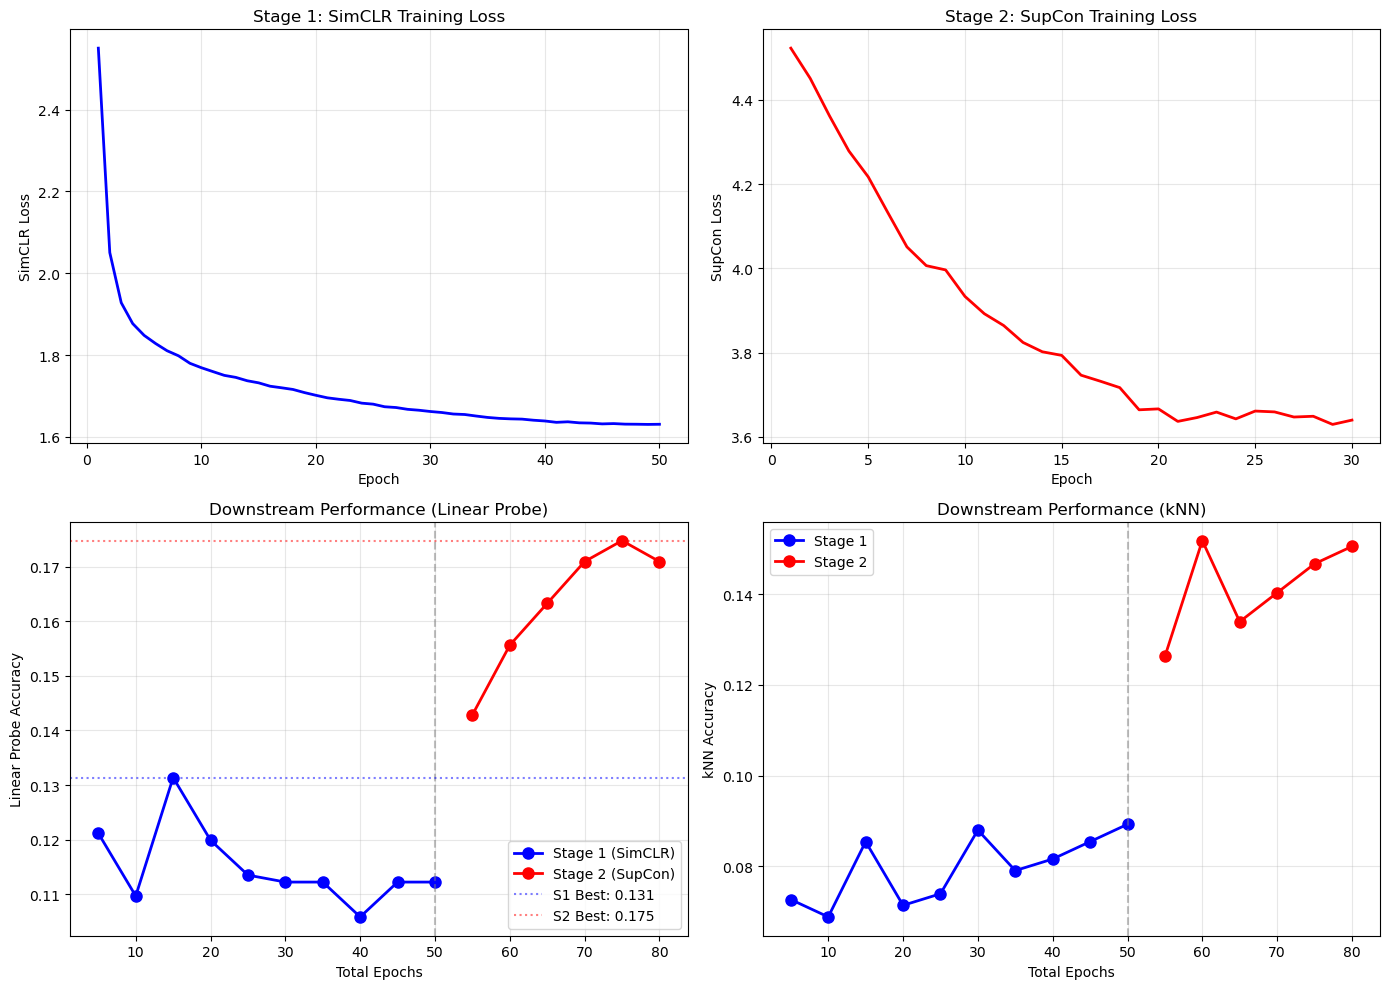

Figure saved: ./supcon_output_2stages\figures/two_stage_training.png


In [23]:
# ============================================================
# Visualization
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Stage 1 Loss
axes[0, 0].plot(range(1, len(stage1_losses)+1), stage1_losses, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('SimCLR Loss')
axes[0, 0].set_title('Stage 1: SimCLR Training Loss')
axes[0, 0].grid(True, alpha=0.3)

# 2. Stage 2 Loss
axes[0, 1].plot(range(1, len(stage2_losses)+1), stage2_losses, 'r-', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('SupCon Loss')
axes[0, 1].set_title('Stage 2: SupCon Training Loss')
axes[0, 1].grid(True, alpha=0.3)

# 3. Linear Probe Accuracy over both stages
all_eval = stage1_eval_history + stage2_eval_history
epochs = [e['epoch'] + (0 if e['stage']==1 else STAGE1_EPOCHS) for e in all_eval]
lp_accs = [e['linear_probe_acc'] for e in all_eval]
stages = [e['stage'] for e in all_eval]

s1_mask = [s==1 for s in stages]
s2_mask = [s==2 for s in stages]

axes[1, 0].plot([e for e,m in zip(epochs, s1_mask) if m], 
                [a for a,m in zip(lp_accs, s1_mask) if m], 
                'bo-', linewidth=2, markersize=8, label='Stage 1 (SimCLR)')
axes[1, 0].plot([e for e,m in zip(epochs, s2_mask) if m],
                [a for a,m in zip(lp_accs, s2_mask) if m],
                'ro-', linewidth=2, markersize=8, label='Stage 2 (SupCon)')
axes[1, 0].axvline(x=STAGE1_EPOCHS, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].axhline(y=best_lp_acc_s1, color='blue', linestyle=':', alpha=0.5, label=f'S1 Best: {best_lp_acc_s1:.3f}')
axes[1, 0].axhline(y=best_lp_acc_s2, color='red', linestyle=':', alpha=0.5, label=f'S2 Best: {best_lp_acc_s2:.3f}')
axes[1, 0].set_xlabel('Total Epochs')
axes[1, 0].set_ylabel('Linear Probe Accuracy')
axes[1, 0].set_title('Downstream Performance (Linear Probe)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. kNN Accuracy
knn_accs = [e['knn_acc'] for e in all_eval]
axes[1, 1].plot([e for e,m in zip(epochs, s1_mask) if m],
                [a for a,m in zip(knn_accs, s1_mask) if m],
                'bo-', linewidth=2, markersize=8, label='Stage 1')
axes[1, 1].plot([e for e,m in zip(epochs, s2_mask) if m],
                [a for a,m in zip(knn_accs, s2_mask) if m],
                'ro-', linewidth=2, markersize=8, label='Stage 2')
axes[1, 1].axvline(x=STAGE1_EPOCHS, color='gray', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Total Epochs')
axes[1, 1].set_ylabel('kNN Accuracy')
axes[1, 1].set_title('Downstream Performance (kNN)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/two_stage_training.png', dpi=150)
plt.show()
print(f"Figure saved: {FIGURES_DIR}/two_stage_training.png")

In [24]:
# ============================================================
# Final Evaluation
# ============================================================

print("="*70)
print("FINAL EVALUATION")
print("="*70)

# Load best model (Stage 2)
best_ckpt = torch.load(f'{CHECKPOINT_DIR}/stage2_best.pth', map_location=device)
model.load_state_dict(best_ckpt['model_state_dict'])
print(f"Loaded best model from Stage 2")

# Final evaluation
final_result = evaluate_model(model, eval_train_loader, eval_val_loader, device)

print(f"\nFinal Results:")
print(f"  Linear Probe Accuracy: {final_result['linear_probe_acc']:.4f}")
print(f"  kNN Accuracy: {final_result['knn_acc']:.4f}")

# Save encoder
encoder_path = f'{OUTPUT_DIR}/oct_encoder_twostage.pth'
torch.save(model.encoder.state_dict(), encoder_path)
print(f"\nEncoder saved to: {encoder_path}")

# Save metrics
metrics = {
    'stage1': {
        'epochs': STAGE1_EPOCHS,
        'dataset_size': len(simclr_train_dataset),
        'best_lp_acc': best_lp_acc_s1,
    },
    'stage2': {
        'epochs': len(stage2_losses),
        'dataset_size': len(supcon_train_dataset),
        'best_lp_acc': best_lp_acc_s2,
    },
    'final': final_result,
    'improvement': best_lp_acc_s2 - best_lp_acc_s1,
    'config': {
        'temperature': TEMPERATURE,
        'embedding_dim': EMBEDDING_DIM,
        'projection_dim': PROJECTION_DIM,
    }
}

with open(f'{OUTPUT_DIR}/training_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print(f"Metrics saved to: {OUTPUT_DIR}/training_metrics.json")

FINAL EVALUATION
Loaded best model from Stage 2



Final Results:
  Linear Probe Accuracy: 0.1747
  kNN Accuracy: 0.1467

Encoder saved to: ./supcon_output_2stages/oct_encoder_twostage.pth
Metrics saved to: ./supcon_output_2stages/training_metrics.json



Computing t-SNE...


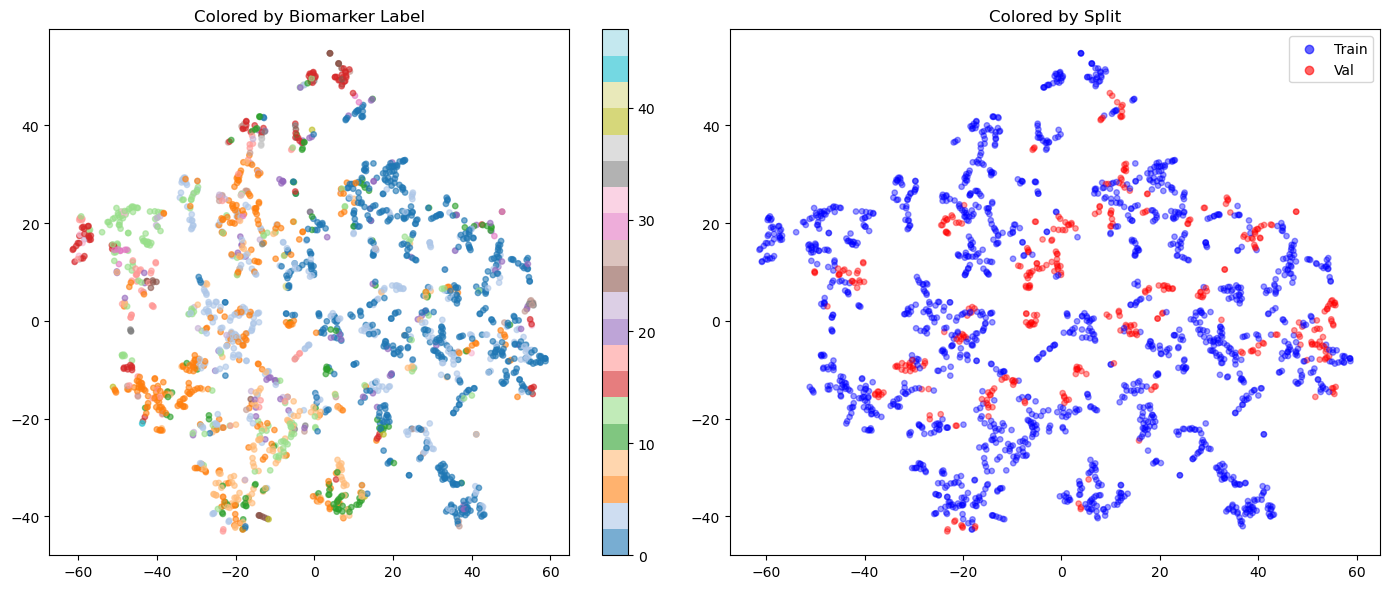

In [25]:
# t-SNE Visualization
from sklearn.manifold import TSNE

print("\nComputing t-SNE...")
train_emb, train_labels = extract_embeddings(model, eval_train_loader, device)
val_emb, val_labels = extract_embeddings(model, eval_val_loader, device)

all_emb = np.vstack([train_emb, val_emb])
all_labels = np.concatenate([train_labels, val_labels])
all_split = np.array(['Train']*len(train_emb) + ['Val']*len(val_emb))

# Subsample
max_samples = 2000
if len(all_emb) > max_samples:
    idx = np.random.choice(len(all_emb), max_samples, replace=False)
    all_emb = all_emb[idx]
    all_labels = all_labels[idx]
    all_split = all_split[idx]

tsne = TSNE(n_components=2, random_state=SEED, perplexity=30)
emb_2d = tsne.fit_transform(all_emb)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# By label
scatter = axes[0].scatter(emb_2d[:, 0], emb_2d[:, 1], c=all_labels, cmap='tab20', alpha=0.6, s=15)
axes[0].set_title('Colored by Biomarker Label')
plt.colorbar(scatter, ax=axes[0])

# By split
colors = ['blue' if s=='Train' else 'red' for s in all_split]
axes[1].scatter(emb_2d[:, 0], emb_2d[:, 1], c=colors, alpha=0.4, s=15)
axes[1].scatter([], [], c='blue', label='Train', alpha=0.6)
axes[1].scatter([], [], c='red', label='Val', alpha=0.6)
axes[1].set_title('Colored by Split')
axes[1].legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/tsne_final.png', dpi=150)
plt.show()

---
# Summary

## Two-Stage Training Approach

| Stage | Data | Loss | Purpose |
|-------|------|------|---------|
| 1 | All ~30,000 images | SimCLR | Learn general OCT visual features |
| 2 | ~3,900 biomarker images | SupCon | Inject clinical semantics |

## Key Benefits
1. **8x more training data** in Stage 1 → reduces overfitting
2. **SimCLR pre-training** provides robust visual features
3. **SupCon fine-tuning** adds biomarker-specific semantics
4. **Linear Probe evaluation** ensures we select based on downstream task performance

## Output Files
- `oct_encoder_twostage.pth` - Final encoder weights
- `training_metrics.json` - Training metrics
- `checkpoints/stage1_best.pth` - Best Stage 1 model
- `checkpoints/stage2_best.pth` - Best Stage 2 model

## Usage
```python
encoder = OCTEncoder(embedding_dim=256, pretrained=False)
encoder.load_state_dict(torch.load('oct_encoder_twostage.pth'))
encoder.eval()

# Extract embedding for an image
embedding = encoder(image_tensor)  # [1, 256]
```